In [1]:
import igraph as ig
import pathlib
import pickle
import tqdm
import time
import pandas as pd
import numpy as np

Specification of data and supplementary dirs

In [3]:
# data_type = '2009-2010'
data_type = '2000-2001'
# data_type = '1999-2000'
# data_type = 'subsample'
DATA_PATH = f'../data arxiv/hyperedges_list_arxiv_{data_type}.txt'
LINEGRAPH_EDGES_PATH = f'../suplementary/linegraphs/linegraph_weighted_edges_list_{data_type}.txt'
LINEGRAPH_NODES_PATH = f'../suplementary/linegraphs/linegraph_weighted_nodes_list_{data_type}.txt'
DIST_DIR = "../suplementary/dist"
CLIQUE_PATH = f"../suplementary/clique-projections/{data_type}-proj-graph.txt"

### Data reading

In [4]:
data_path = DATA_PATH
with open(data_path) as file:
    line = file.readline()

if data_type in ["subsample", "test"]:
    hyperedges_list = line.split('], ')
    hyperedges_list = [x.replace('[','') for x in hyperedges_list]
    hyperedges_list = [x.replace(']','') for x in hyperedges_list] # removes the last "]""
else:
    hyperedges_list = line.split(']", ')
    hyperedges_list = [x.replace('"[','') for x in hyperedges_list]
    hyperedges_list = [x.replace(']"','') for x in hyperedges_list] # removes the last "]""
    
print(len(hyperedges_list))
print(hyperedges_list[0])
print(hyperedges_list[-1])

8914
'hep-ex', 'physics.comp-ph'
'math.ag', 'math.cv'


In [5]:
hyperedges_list, counts_list = np.unique(hyperedges_list, return_counts = True) # counts_list contains info about frequencies of each hyperedge
print(len(hyperedges_list))
print(len(counts_list))

hyperedges_list = [x.replace("'",'') for x in hyperedges_list]
hyperedges_list = [x.split(', ') for x in hyperedges_list]
print(hyperedges_list[:3])
print(counts_list[:3])

2205
2205
[['astro-ph', 'astro-ph.ga'], ['astro-ph', 'cond-mat'], ['astro-ph', 'cond-mat', 'gr-qc', 'hep-ph']]
[1 1 2]


In [7]:
# left hyperedges of size 1
hyperedges_list_ids = [i for i in range(len(hyperedges_list)) if len(hyperedges_list[i]) > 1]
print(len(hyperedges_list_ids))
if len(hyperedges_list_ids) < len(hyperedges_list):
    hyperedges_list = [hyperedges_list[i] for i in hyperedges_list_ids]
    counts_list = [counts_list[i] for i in hyperedges_list_ids]

2205


In [10]:
# create supplementary dictionary containing nodes as keys and hyperedges to which they are incident as values. It helps to access needed hyperedges faster
def get_nodes_to_edges(edges_to_nodes_dict):
    nodes_to_edges_dict = {}
    for edge, nodes in edges_to_nodes_dict.items():
        for node in nodes:
            if node in nodes_to_edges_dict.keys():
                nodes_to_edges_dict[node].append(edge)
            else:
                nodes_to_edges_dict[node] = [edge]
    return nodes_to_edges_dict

In [11]:
edges_to_nodes_dict = {i: hyperedges_list[i] for i in range(len(hyperedges_list))} # key = hyperedge, value = nodes in hyperedge
edges_to_counts_dict = {i: counts_list[i] for i in range(len(counts_list))}
nodes_to_edges_dict = get_nodes_to_edges(edges_to_nodes_dict) # key = node, value = list of hyperedges in which the node participates
print(f'nodes count = {len(nodes_to_edges_dict.keys())}')

nodes count = 135


### Line-graph construction functions

In [12]:
# weight_function is needed for creation of weighted line graph, w1 (w2) is e1's (e2's) weight in weighted hypergraph
def weight_function(e1, e2, w1, w2):
    if e1 == e2:
        return (1 / w1) * ((1 / 3) * (len(e1) + 1) - 1)
    union_len = len(set(e1).union(e2))
    intersect_len = len(set(e1).intersection(e2))
    return (1 / 2) * (1 / w1 + 1 / w2) *((1 / 3) * union_len * (1 + 1 / intersect_len) - 1)


def generate_weighted_line_graph(edges_to_nodes_dict, edges_to_counts_dict):
    file_path = pathlib.Path(LINEGRAPH_EDGES_PATH)
    
    if not file_path.exists():

        items = list(edges_to_nodes_dict.items())
        line_nodes_ids_dict = {items[i][0]: i for i in range(len(items))} # in line-graph nodes = hyperedges in intial hypergraph
        line_edges_list = [] 
        line_edges_weights_list = []

        for i in range(len(items)):
            edge, nodes = items[i]    
            line_edges_list.append([i,i]) # our line-graph has self-loops
            line_edges_weights_list.append(weight_function(nodes, nodes, 
                                                           edges_to_counts_dict[edge], edges_to_counts_dict[edge])) # add weights of self-loops

        for i in tqdm.tqdm(range(len(items))):    
            edge, nodes = items[i]
            set_nodes = set(nodes)
            neighbors = [k for k,v in items if 
                         not k == edge and
                         (len(v) >= len(nodes)) and 
                         not set_nodes.isdisjoint(v)] # find hyperedges that intersect with the current one
            
            if len(neighbors) > 0:
                for neighbor in neighbors:
                    line_edges_list.append([line_nodes_ids_dict[edge],line_nodes_ids_dict[neighbor]]) # each intersection leads to edge in the line-graph
                    line_edges_weights_list.append(weight_function(nodes, edges_to_nodes_dict[neighbor], 
                                                                   edges_to_counts_dict[edge], edges_to_counts_dict[neighbor])) 
        
        G = ig.Graph(n=len(items), edges=line_edges_list, 
                        edge_attrs={'weight': line_edges_weights_list},
                        vertex_attrs={'label': list(line_nodes_ids_dict.keys())})
        edges_list = G.get_edgelist()
        print('saving line graph')
        with open(LINEGRAPH_EDGES_PATH,'w') as file:
            lines = []
            for edge_id in range(len(edges_list)):
                edge_weight = G.es[edge_id]["weight"]
                lines.append(f'{edges_list[edge_id][0]} {edges_list[edge_id][1]} {edge_weight}\n')
            file.writelines(lines)
        with open(LINEGRAPH_NODES_PATH ,'w') as file:
            file.writelines([str(G.vs[i]['label'])+'\n' for i in range(len(items))])
        
        print('line graph saved')
        del G
    
    with open(LINEGRAPH_EDGES_PATH,'r') as file:
        lines = file.readlines()
    with open(LINEGRAPH_NODES_PATH,'r') as file:
        lines_nodes = file.readlines()
    edges_list = []
    weights = []
    nodes = []
    print('preparing data for line graph creation')
    print(len(lines))
    for line in lines:
        from_node,to_node,weight = line.split(' ')
        from_node = int(from_node)
        to_node = int(to_node)
        if from_node not in nodes:
            nodes.append(from_node)
        if to_node not in nodes:
            nodes.append(to_node)
        weight = float(weight)
        edges_list.append((from_node,to_node))
        weights.append(weight)

    print('line graph creation')
    G = ig.Graph(n = len(nodes), edges=edges_list, 
                            edge_attrs={'weight': weights},
                            vertex_attrs={'label': [int(x) for x in lines_nodes]})
    return G



### Hypergraph distance calculation function

In [13]:
# to find shortest path from node u to node v one should, first, find path in line-graph from all nodes, representing hyperedges to which u belongs, to all nodes, representing all hyperedges to which v belongs 
# each hyperedge contains sereis of nodes, therefore,  paths between nodes in the line-graph might be the same for different node pairs.
# To fasten calculation we can save shortest paths that we have already found  
# global_all_path_dict contains information about previously found paths between nodes in line-graph (representing hyperedges in hypergraph)

def get_distance_new(nodes_to_edges_dict, edges_to_counts_dict, line_graph, u, v, global_all_path_dict = {}, return_path = False):
    from_edges = nodes_to_edges_dict[u] # from_edges - edges incident to node u
    to_edges = nodes_to_edges_dict[v] # to_edges - edges incident to node v 

    if len(from_edges) < len(to_edges):
        u_edges = from_edges
        v_edges = to_edges
    else:
        u_edges = to_edges
        v_edges = from_edges

    line_nodes_ids_dict = {line_graph.vs["label"][i]: i for i in range(len(line_graph.vs["label"]))} 
    line_ids_nodes_dict = {i : line_graph.vs["label"][i] for i in range(len(line_graph.vs["label"]))}

    uv_dist = []
    uv_paths = []
    
    for u_e in u_edges:
        if u_e in global_all_path_dict.keys():
            all_paths_dict = global_all_path_dict[u_e].copy()
        else:
            all_paths_dict = {}
        to_linegraph_nodes = [v_e for v_e in v_edges if v_e not in all_paths_dict.keys() and not v_e == u_e] # nodes in line-graph to which paths from u_e have not been found previously 

        drop_ve = []
        for v_e in to_linegraph_nodes:
            if v_e in global_all_path_dict.keys(): # paths are not directed. If we already have path from v_e to u_e it is the same path as from u_e to v_e and we should not find it once more
                if u_e in global_all_path_dict[v_e].keys():
                    all_paths_dict[v_e] = [list(np.flip(x)) for x in global_all_path_dict[v_e][u_e]]
                    drop_ve.append(v_e)

        all_paths = line_graph.get_all_shortest_paths(line_nodes_ids_dict[u_e], 
                                                      to = [line_nodes_ids_dict[x] for x in to_linegraph_nodes if x not in drop_ve], 
                                                      weights=line_graph.es["weight"]) # calculation of absent shortest paths 
        
        for i in range(len(all_paths)): # collecting of the new shortest paths
            if len(all_paths[i]) > 1:
                if not line_ids_nodes_dict[all_paths[i][-1]] in all_paths_dict.keys():
                    all_paths_dict[line_ids_nodes_dict[all_paths[i][-1]]] = [all_paths[i]]

                    if not line_ids_nodes_dict[all_paths[i][-1]] in global_all_path_dict.keys():
                        global_all_path_dict[line_ids_nodes_dict[all_paths[i][-1]]] = {u_e : [list(np.flip(all_paths[i]))]}
                    else:
                        global_all_path_dict[line_ids_nodes_dict[all_paths[i][-1]]][u_e] = [list(np.flip(all_paths[i]))]
                else:
                    all_paths_dict[line_ids_nodes_dict[all_paths[i][-1]]].append(all_paths[i])
                    global_all_path_dict[line_ids_nodes_dict[all_paths[i][-1]]][u_e].append(list(np.flip(all_paths[i])))
        
        global_all_path_dict[u_e] = all_paths_dict.copy() # saving of the renewed collection of the shortest paths from u_e
        
        for v_e in v_edges: # calculate distances between u and v corresponding to every u_e -> v_e 
            if u_e == v_e:
                dist = line_graph.es["weight"][line_graph.get_eid(line_nodes_ids_dict[u_e],line_nodes_ids_dict[v_e])]
                uv_dist.append(dist + 1 / edges_to_counts_dict[u_e]) # modification for weighted hypergraph
                uv_paths.append([line_graph.get_eid(line_nodes_ids_dict[u_e],line_nodes_ids_dict[v_e])])
            else:
                paths = all_paths_dict[v_e]
                uv_paths.append(paths)
                if len(paths[0]) > 0:
                    distance = 0
                for i in range (len(paths[0]) - 1):
                    start = paths[0][i]
                    end = paths[0][i + 1]
                    e = line_graph.get_eid(start, end)
                    distance += line_graph.es[e]["weight"]
                    # uv_paths[-1].append((start,end))
                distance += (1 / 2) * (1 / edges_to_counts_dict[u_e] + 1 / edges_to_counts_dict[v_e])
                uv_dist.append(distance)
    
    if not return_path:
        return min(uv_dist), global_all_path_dict
    
    min_indexes = [i for i in range(len(uv_dist)) if uv_dist[i] == min(uv_dist)] # indexes corresponding to minimal distance between differen u_e and v_e pairs

    paths = []
    for i in min_indexes:
        if len(uv_paths[i]) > 1:
            paths_str = [",".join([str(y) for y in x]) for x in uv_paths[i] ]
            paths_str = np.unique(paths_str)
            paths_tmp = [x.split(',') for x in paths_str]
            paths_tmp = [[int(y) for y in x] for x in paths_tmp]
            paths.extend(paths_tmp)
        else:
            paths.extend(uv_paths[i].copy())

    return min(uv_dist), paths, global_all_path_dict

In [14]:
# suplementary function to calculate particulare path length
def calc_path_weight(edges_to_counts_dict, line_graph, path):
    line_ids_nodes_dict = {i : line_graph.vs["label"][i] for i in range(len(line_graph.vs["label"]))}
    length = 0
    for i in range (len(path) - 1):
        start = path[i]
        end = path[i + 1]
        e = line_graph.get_eid(start, end)
        length += line_graph.es[e]["weight"]
    length += (1 / 2) * (1 / edges_to_counts_dict[line_ids_nodes_dict[path[0]]] +\
                          1 / edges_to_counts_dict[line_ids_nodes_dict[path[-1]]])
    return length

### Line-graph generation

In [16]:
# if we constructed line-graph once it is saved into suplementary/linegraphs to fasten further calculation
line_graph = generate_weighted_line_graph(edges_to_nodes_dict, edges_to_counts_dict)

preparing data for line graph creation
539052
line graph creation


### Computation of distances between specified pairs of nodes

In [17]:
dists_dict = {}
paths_dict = {}
node_names = list(nodes_to_edges_dict.keys())
start_id = 0
final_id = len(node_names) - 1
# start_id = 120
# final_id = 120
file_path = pathlib.Path(f'{DIST_DIR}/dists_{data_type}_weighted-{start_id}-{final_id}.pickle')

global_all_path_dict = {}
    
if not file_path.exists():
    time_start = time.time()
    for id_from in range(start_id,final_id + 1):
        node_from = node_names[id_from]
        dists = []
        paths = []
        print(id_from)
        for node in list(nodes_to_edges_dict.keys()):
            if not node == node_from:
                dist, paths_tmp, global_all_path_dict = get_distance_new(nodes_to_edges_dict, edges_to_counts_dict, line_graph, node_from, node, global_all_path_dict, return_path=True)
                dists.append(dist)
                paths.append(paths_tmp)
            else:
                dists.append(0)
                paths.append([])
        dists_dict[node_from] = dists.copy()
        paths_dict[node_from] = paths.copy()
        with open(f'{DIST_DIR}/dists_{data_type}_weighted-{start_id}-{final_id}.pickle', 'wb') as handle: # we save calculated distances and corresponding shortest paths to fasten furter analysis
                pickle.dump((dists_dict, paths_dict), handle)
    time_term = time.time()
    print(f'Elapsed time {time_term - time_start}')
else:
    with open(f'{DIST_DIR}/dists_{data_type}_weighted-{start_id}-{final_id}.pickle', 'rb') as handle:
        dists_dict, paths_dict = pickle.load(handle)

In [18]:
# data frame containing calculated distances between every nodes pair
hyper_dist_df = pd.DataFrame(dists_dict)
hyper_dist_df.index = list(nodes_to_edges_dict.keys())
hyper_dist_df

,astro-ph,astro-ph.ga,cond-mat,gr-qc,hep-ph,nucl-th,hep-ex,nucl-ex,physics.ins-det,physics.atom-ph,...,math.at,math.ac,math.gn,math.ho,q-bio.gn,q-bio.ot,physics.gen-ph,q-bio.sc,q-bio.qm,q-bio.to
astro-ph,0.000000,1.000000,0.055532,0.009804,0.007692,0.012955,0.013407,0.034367,0.430073,0.132692,...,0.192327,0.105532,0.292327,0.574763,0.949698,1.274282,0.285660,1.312765,1.555532,2.118032
astro-ph.ga,1.000000,0.000000,1.055532,1.009804,1.007692,1.012955,1.013407,1.034367,1.430073,1.132692,...,1.192327,1.105532,1.292327,1.574763,1.949698,2.274282,1.285660,2.312765,2.555532,3.118032
cond-mat,0.055532,1.055532,0.000000,0.047222,0.047840,0.053103,0.053554,0.074514,0.470220,0.172840,...,0.220128,0.133333,0.320128,0.602564,0.977500,1.218750,0.271795,1.276923,1.500000,2.062500
gr-qc,0.009804,1.009804,0.047222,0.000000,0.011728,0.016992,0.017443,0.038403,0.434109,0.136728,...,0.184017,0.097222,0.284017,0.566453,0.941304,1.265972,0.277350,1.305556,1.547222,2.109722
hep-ph,0.007692,1.007692,0.047840,0.011728,0.000000,0.005263,0.005714,0.026675,0.422381,0.125000,...,0.184634,0.097840,0.284634,0.567070,0.942006,1.266590,0.277968,1.305072,1.547840,2.110340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
q-bio.ot,1.274282,2.274282,1.218750,1.265972,1.266590,1.271853,1.272304,1.293264,1.688970,1.391590,...,1.438878,1.352083,1.538878,1.821314,2.196250,0.000000,1.490545,2.200000,2.406250,2.968750
physics.gen-ph,0.285660,1.285660,0.271795,0.277350,0.277968,0.283231,0.283682,0.304642,0.700349,0.250000,...,0.450256,0.363462,0.550256,0.832692,1.191709,1.490545,0.000000,1.515933,1.771795,2.334295
q-bio.sc,1.312765,2.312765,1.276923,1.305556,1.305072,1.310336,1.310787,1.331747,1.727453,1.430072,...,1.478462,1.391667,1.578462,1.860897,2.233904,2.200000,1.515933,0.000000,2.659091,3.221591
q-bio.qm,1.555532,2.555532,1.500000,1.547222,1.547840,1.553103,1.553554,1.574514,1.916667,1.672840,...,1.720128,1.633333,1.820128,2.102564,2.477500,2.406250,1.771795,2.659091,0.000000,2.333333


### Weighted clique projection

In [19]:
# function generating weighted clique projection
# weights = 1 / frequency of appearance
def make_clique_projection_data(edges_to_nodes_dict, edges_to_counts_dict):
    file_path = pathlib.Path(CLIQUE_PATH)
    
    if not file_path.exists():
        proj_edges_dict = {}
        for edge, nodes in edges_to_nodes_dict.items():
            for i in range(len(nodes)-1):
                for j in range(i+1, len(nodes)):
                    node_from = nodes[i]
                    node_to = nodes[j]
                    if not (((node_from, node_to) in proj_edges_dict.keys()) 
                            or ((node_to, node_from) in proj_edges_dict.keys())):
                        proj_edges_dict[(node_from,node_to)] = edges_to_counts_dict[edge]
                    else:
                        if ((node_from, node_to) in proj_edges_dict.keys()):
                            proj_edges_dict[(node_from,node_to)] += edges_to_counts_dict[edge]
                        else:
                            proj_edges_dict[(node_to,node_from)] += edges_to_counts_dict[edge]
        
        with open(CLIQUE_PATH, 'w') as handle:
            for (node_from, node_to), weight in proj_edges_dict.items():
                handle.write(f'{node_from} {node_to} {weight}')
                handle.write('\n')

In [111]:
# first, create cluque projection if it wasn't created previously
make_clique_projection_data(edges_to_nodes_dict, edges_to_counts_dict)

# load and clique projection
proj_graph_file = CLIQUE_PATH
with open(proj_graph_file) as file:
        lines = file.readlines()
        edges_list = []
        weights_list = []
        nodes_dict = {}
        i = -1
        for line in lines:
            from_node, to_node, weight = line.split(" ")
            
            # from_node = int(from_node)
            # to_node = int(to_node)
     
            if not from_node in nodes_dict.keys():
                i += 1
                from_id = i
                nodes_dict[from_node] = i
            else:
                from_id = nodes_dict[from_node]
            if not to_node in nodes_dict.keys():
                i += 1
                to_id = i
                nodes_dict[to_node] = i
            else:
                to_id = nodes_dict[to_node]
            edges_list.append([from_id, to_id])
            weights_list.append(1 / float(weight))

proj_graph = ig.Graph(edges_list)
proj_graph.es["weight"] = weights_list

proj_dist_dict = {}
proj_dist_path = {}

# calculation of distances and paths in cluque projection

for from_node in dists_dict.keys():
    from_node_id = nodes_dict[from_node]
    dists = []
    paths_tmp = []
    for node in list(nodes_to_edges_dict.keys()):
        node_id = nodes_dict[node]
        paths = proj_graph.get_shortest_paths(from_node_id, node_id, weights=proj_graph.es["weight"], output = "epath")
        paths_tmp.append(paths[0])
        distance = 0
        for e in paths[0]:
            distance += proj_graph.es[e]["weight"]
        dists.append(distance)

    proj_dist_dict[from_node] = dists
    proj_dist_path[from_node] = paths_tmp


# data frame containing dists in clique proj for every nodes pair
proj_dist_df = pd.DataFrame(proj_dist_dict)
proj_dist_df.index = list(nodes_to_edges_dict.keys())
proj_dist_df

,astro-ph,astro-ph.ga,cond-mat,gr-qc,hep-ph,nucl-th,hep-ex,nucl-ex,physics.ins-det,physics.atom-ph,...,math.at,math.ac,math.gn,math.ho,q-bio.gn,q-bio.ot,physics.gen-ph,q-bio.sc,q-bio.qm,q-bio.to
astro-ph,0.000000,1.000000,0.010346,0.001938,0.001585,0.003135,0.004244,0.009802,0.095153,0.031861,...,0.063389,0.035340,0.198869,0.526560,0.377235,0.540310,0.098528,0.543902,0.293902,0.543902
astro-ph.ga,1.000000,0.000000,1.010346,1.001938,1.001585,1.003135,1.004244,1.009802,1.095153,1.031861,...,1.063389,1.035340,1.198869,1.526560,1.377235,1.540310,1.098528,1.543902,1.293902,1.543902
cond-mat,0.010346,1.010346,0.000000,0.008863,0.008761,0.010312,0.011421,0.016978,0.102330,0.034006,...,0.067968,0.039919,0.203448,0.531139,0.381814,0.544890,0.100672,0.548481,0.298481,0.548481
gr-qc,0.001938,1.001938,0.008863,0.000000,0.002699,0.004250,0.005359,0.010916,0.096268,0.030378,...,0.061906,0.033857,0.197386,0.525077,0.375752,0.538827,0.097045,0.542419,0.292419,0.542419
hep-ph,0.001585,1.001585,0.008761,0.002699,0.000000,0.001550,0.002660,0.008217,0.093569,0.030276,...,0.061804,0.033755,0.197284,0.524975,0.375650,0.538726,0.096943,0.542317,0.292317,0.542317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
q-bio.ot,0.540310,1.540310,0.544890,0.538827,0.538726,0.540276,0.541385,0.546943,0.632294,0.566404,...,0.597903,0.569883,0.733383,1.061103,0.833333,0.000000,0.633071,1.000000,0.750000,1.000000
physics.gen-ph,0.098528,1.098528,0.100672,0.097045,0.096943,0.098493,0.099602,0.105160,0.190511,0.066667,...,0.154274,0.128100,0.289754,0.619320,0.469995,0.633071,0.000000,0.636662,0.386662,0.636662
q-bio.sc,0.543902,1.543902,0.548481,0.542419,0.542317,0.543867,0.544976,0.550534,0.635885,0.569995,...,0.601494,0.573474,0.736974,1.064694,0.833333,1.000000,0.636662,0.000000,0.750000,1.000000
q-bio.qm,0.293902,1.293902,0.298481,0.292419,0.292317,0.293867,0.294976,0.300534,0.385885,0.319995,...,0.351494,0.323474,0.486974,0.814694,0.583333,0.750000,0.386662,0.750000,0.000000,0.750000


### Analysis and comparison

In [113]:
hyper_dist_df.to_csv(f"results_hypergraph_dist_{data_type}.csv")
proj_dist_df.to_csv(f"results_clique-proj_dist_{data_type}.csv")

In [114]:
all_hg_dists = []
all_proj_dists = []

for i in range(len(node_names)-1):
    for j in range(i + 1,len(node_names)):
        from_node = node_names[i]
        to_node = node_names[j]
        if not from_node == to_node:
            all_hg_dists.append(dists_dict[from_node][j])
            all_proj_dists.append(proj_dist_dict[from_node][j])
max_q = 10
hg_quantiles = [np.quantile(all_hg_dists, q/max_q) for q in range(1,max_q)]
proj_quantiles = [np.quantile(all_proj_dists, q/max_q) for q in range(1,max_q)]



In [115]:
hg_quantiles

[np.float64(0.20941672261299457),
 np.float64(0.3432864326004806),
 np.float64(0.5779771910188577),
 np.float64(0.8333333333333333),
 np.float64(1.0),
 np.float64(1.1465824915824914),
 np.float64(1.401288163428514),
 np.float64(1.7000984714873608),
 np.float64(2.0711951447245562)]

In [116]:
proj_quantiles

[np.float64(0.057495756466371103),
 np.float64(0.1130564541463953),
 np.float64(0.20374404196592044),
 np.float64(0.3061495097460101),
 np.float64(0.4346688608983691),
 np.float64(0.5588557751982853),
 np.float64(0.7191151559536888),
 np.float64(1.0277816627816627),
 np.float64(1.2397186147186148)]

In [118]:
compare_dict = {
    "from node id":[],
    "to node id":[],
    "from node":[],
    "to node":[],
    "hypergraph distance":[],
    "projected distance":[],
    "diff":[],
    "hypergraph rank":[],
    "projected rank":[],
    "rank difference": []
}
for i in range(len(node_names)-1):
    for j in range(i + 1,len(node_names)):
        from_node = node_names[i]
        to_node = node_names[j]
        hg_dist = dists_dict[from_node][j]
        proj_dist = proj_dist_dict[from_node][j]
        
        if hg_dist <= hg_quantiles[0]:
            compare_dict["hypergraph rank"].append(1)
        elif hg_dist > hg_quantiles[-1]:
            compare_dict["hypergraph rank"].append(max_q)
        else:
            for q in range(1,max_q - 1):
                if hg_dist > hg_quantiles[q-1] and hg_dist <= hg_quantiles[q]:
                    compare_dict["hypergraph rank"].append(q+1) 

        if proj_dist <= proj_quantiles[0]:
            compare_dict["projected rank"].append(1)
        elif proj_dist > proj_quantiles[-1]:
            compare_dict["projected rank"].append(max_q)
        else:
            for q in range(1,max_q - 1):
                if proj_dist > proj_quantiles[q-1] and proj_dist <= proj_quantiles[q]:
                    compare_dict["projected rank"].append(q+1) 
                
        compare_dict["from node id"].append(i)
        compare_dict["to node id"].append(j)
        compare_dict["from node"].append(from_node)
        compare_dict["to node"].append(to_node)
        compare_dict["hypergraph distance"].append(hg_dist)
        compare_dict["projected distance"].append(proj_dist)
        compare_dict["diff"].append(hg_dist - proj_dist)
        compare_dict["rank difference"].append(abs(compare_dict["projected rank"][-1] - compare_dict["hypergraph rank"][-1]))

In [119]:
compare_df = pd.DataFrame(compare_dict)

In [123]:
compare_df.sort_values(by=["rank difference"],ascending=False, inplace=True)
compare_df.to_csv(f"compare_{data_type}.csv", sep=",")

In [124]:
compare_df

,from node id,to node id,from node,to node,hypergraph distance,projected distance,diff,hypergraph rank,projected rank,rank difference
6631,65,67,q-fin.st,q-fin.rm,0.804315,1.030303,-0.225988,4,9,5
4857,42,133,cs.lg,q-bio.qm,2.234301,0.392857,1.841444,10,5,5
4321,37,67,physics.bio-ph,q-fin.rm,0.849770,1.029907,-0.180137,5,9,4
8873,115,134,math.ag,q-bio.to,2.145833,0.553066,1.592767,10,6,4
7394,77,80,physics.med-ph,cs.ai,1.846795,0.358639,1.488155,9,5,4
...,...,...,...,...,...,...,...,...,...,...
8772,111,115,math.dg,math.ag,0.052632,0.014286,0.038346,1,1,0
8771,111,114,math.dg,math.ca,0.240247,0.057503,0.182745,2,2,0
8770,111,113,math.dg,math.lo,0.383333,0.126923,0.256410,3,3,0
8358,97,114,cs.gl,math.ca,1.869970,1.128092,0.741878,9,9,0


In [98]:
quant_matrix = np.zeros(shape=(max_q,max_q))

N_pairs = len(compare_dict["hypergraph rank"])

for i in range(N_pairs):
    h_rank = compare_dict["hypergraph rank"][i]
    g_rank = compare_dict["projected rank"][i]
    quant_matrix[h_rank - 1, g_rank - 1] += 1 / N_pairs


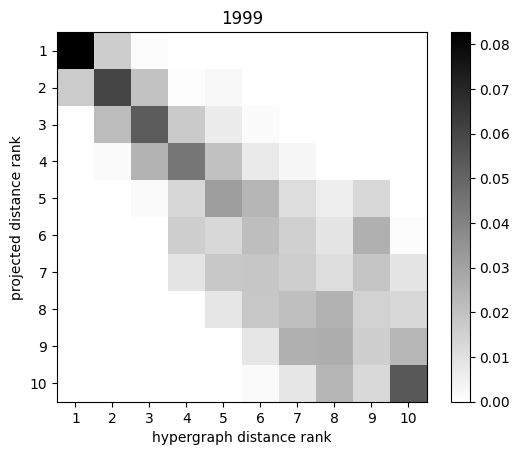

In [73]:
import matplotlib.pyplot as plt

plt.imshow(quant_matrix, cmap="binary", )
plt.xticks(range(0,max_q),labels=range(1,max_q + 1))
plt.yticks(range(0,max_q),labels=range(1,max_q + 1))
plt.xlabel('hypergraph distance rank')
plt.ylabel('projected distance rank')
plt.colorbar()
plt.title(data_type[:4])
plt.savefig(f'../figures/ranks_dist_{data_type}.pdf')


In [125]:
from_name = "q-fin.st"
to_name = "q-fin.rm"
from_id = 65
to_id = 67
dists_dict[from_name][to_id]

np.float64(0.8043154761904763)

In [126]:
proj_dist_dict[from_name][to_id]

1.0303030303030303

In [127]:
paths_dict[from_name][to_id]

[[271, 256, 441]]

In [128]:

for edge in paths_dict[from_name][to_id][0]:
    string = ''
    for x in edges_to_nodes_dict[edge]:
        string += x + ' '
    print(f'{string} weight = {edges_to_counts_dict[edge]}')

cond-mat.soft cond-mat.stat-mech q-fin.rm  weight = 1
cond-mat.soft cond-mat.stat-mech  weight = 112
cond-mat.stat-mech q-fin.st  weight = 21


In [129]:
proj_dist_path[from_name][to_id]

[389, 373]

In [130]:
for edge in proj_dist_path[from_name][to_id]:
    print(f'weight = {1 / proj_graph.es[edge]["weight"]}')
    print(node_names[proj_graph.es[edge].source])
    print(node_names[proj_graph.es[edge].target])

weight = 33.0
cond-mat.stat-mech
q-fin.st
weight = 1.0
cond-mat.stat-mech
q-fin.rm
